<a href="https://www.kaggle.com/code/np8113/indian-electoral-bond-analysis?scriptVersionId=167165277" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/election-dates-2019-2023/State_Election_Dates.csv
/kaggle/input/electoral-bonds-dataset/electroral_bonds_buyer_data.csv
/kaggle/input/electoral-bonds-dataset/electroral_bonds_receiver_data.csv


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
buy_df = pd.read_csv('/kaggle/input/electoral-bonds-dataset/electroral_bonds_buyer_data.csv',index_col=[0])
print('Electoral Bond Purchase data: ')
buy_df.head().style.hide(axis="index")

Electoral Bond Purchase data: 


Date of Purchase,Purchaser Name,Denomination
12/Apr/2019,A B C INDIA LIMITED,100000
12/Apr/2019,A B C INDIA LIMITED,100000
12/Apr/2019,A B C INDIA LIMITED,1000000
12/Apr/2019,A B C INDIA LIMITED,1000000
12/Apr/2019,A B C INDIA LIMITED,100000


In [4]:
rec_df = pd.read_csv('/kaggle/input/electoral-bonds-dataset/electroral_bonds_receiver_data.csv',index_col=[0])
# Renaming columns
rec_df.rename(columns={'Date of\nEncashment':'Date of Encashment',
                       'Name of the Political Party': 'Party Name'}, inplace=True)
print('Electoral Bond Encash / Redeem data: ')
rec_df.head().style.hide(axis="index")

Electoral Bond Encash / Redeem data: 


Date of Encashment,Party Name,Denomination
12/Apr/2019,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000
12/Apr/2019,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000
12/Apr/2019,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,10000000
12/Apr/2019,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000
12/Apr/2019,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,1000000


- As there is no identifier between 'Purchase' data and 'Encashment' data it will be hard to join them together  
- We will have to do individual analysis

In [5]:
elec_date = pd.read_csv('/kaggle/input/election-dates-2019-2023/State_Election_Dates.csv')
print('Election data of 2019-2023: ')
elec_date.head().style.hide(axis="index")

Election data of 2019-2023: 


State/ Union Territory,Election Year,Result Date,Majority Party,Government
Andhra Pradesh,2019,23 May 2019,YSRCP,YSR Congress Party
Arunachal Pradesh,2019,23 May 2019,BJP,National Democratic Alliance
Haryana,2019,24 October 2019,BJP,National Democratic Alliance
Jharkhand,2019,23 December 2019,JMM,Indian National Developmental Inclusive Alliance
Maharashtra,2019,24 October 2019,BJP,National Democratic Alliance


\*Source: https://en.wikipedia.org/wiki/List_of_Indian_state_legislative_assembly_elections  
One can scrape the wikipedia table and use it directly.  
I copy pasted it into a file then uploaded it in Kaggle

## Pre Processing

### Converting String to Date Time

In [6]:
buy_df['Date of Purchase'] = pd.to_datetime(buy_df['Date of Purchase'])
buy_df.dtypes

Date of Purchase    datetime64[ns]
Purchaser Name              object
Denomination                 int64
dtype: object

In [7]:
rec_df['Date of Encashment'] = pd.to_datetime(rec_df['Date of Encashment'])
rec_df.dtypes

Date of Encashment    datetime64[ns]
Party Name                    object
Denomination                   int64
dtype: object

### Aggregating Data on Date and Purchaser / Party

In [8]:
# Aggregating, As there are multiple entries for the same day for the same purchaser
agg_buy_df = buy_df.groupby(by=['Date of Purchase', 'Purchaser Name']
                           ).sum().reset_index().set_index('Date of Purchase')
agg_buy_df.head()

,Purchaser Name,Denomination
Date of Purchase,,
2019-04-12,A B C INDIA LIMITED,4000000
2019-04-12,ACROPOLIS MAINTENANCE SERVICES PRIVATE LIMITED,2500000
2019-04-12,ARIHANT ENTERPRISES,4000000
2019-04-12,CHOUDHARY GARMENTS,2000000
2019-04-12,ESSEL MINING AND INDS LTD,500000000


In [9]:
# Aggregating, As there are multiple entries for the same day for the same Party
agg_rec_df = rec_df.groupby(by=['Date of Encashment', 'Party Name']
                           ).sum().reset_index().set_index('Date of Encashment')
agg_rec_df.head()

,Party Name,Denomination
Date of Encashment,,
2019-04-12,ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM,60000000
2019-04-12,BHARAT RASHTRA SAMITHI,225000000
2019-04-12,BHARTIYA JANTA PARTY,2463000000
2019-04-12,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",101000000
2019-04-12,SHIVSENA (POLITICAL PARTY),37000000


In [10]:
print("Minimum Date in Purchase data:",agg_buy_df.index.min())
print("Maximum Date in Purchase data:",agg_buy_df.index.max())
print('-'*50)
print("Minimum Date in Encashed data:",agg_rec_df.index.min())
print("Maximum Date in Encashed data:",agg_rec_df.index.max())

Minimum Date in Purchase data: 2019-04-12 00:00:00
Maximum Date in Purchase data: 2024-01-11 00:00:00
--------------------------------------------------
Minimum Date in Encashed data: 2019-04-12 00:00:00
Maximum Date in Encashed data: 2024-01-24 00:00:00


- As we have data from **April 2019** to **Jan 2024**.  
- We will use data from 2020 to 2023 for our Analysis as they contain entire years data

In [11]:
# Limiting the time range for both dataset

agg_buy_df = agg_buy_df.loc[(agg_buy_df.index >'2020-01-01') & (agg_buy_df.index<'2023-12-31')]
agg_rec_df = agg_rec_df.loc[(agg_rec_df.index >'2020-01-01') & (agg_rec_df.index<'2023-12-31')]

In [12]:
# Creating new columns from the Date

agg_buy_df['Month'] = agg_buy_df.index.month
agg_buy_df['Quarter'] = agg_buy_df.index.quarter
agg_buy_df['Year'] = agg_buy_df.index.year

agg_rec_df['Month'] = agg_rec_df.index.month
agg_rec_df['Quarter'] = agg_rec_df.index.quarter
agg_rec_df['Year'] = agg_rec_df.index.year

In [13]:
# 'Y-M' column represent date in the format 'Year-Month'
agg_buy_df['Y-M'] = agg_buy_df['Year'].astype('str')+'-'+agg_buy_df['Month'].astype('str')
agg_rec_df['Y-M'] = agg_rec_df['Year'].astype('str')+'-'+agg_rec_df['Month'].astype('str')

In [14]:
# 'Y-Q' column represent date in the format 'Year-Quarter'
agg_buy_df['Y-Q'] = agg_buy_df['Year'].astype('str')+'-Q'+agg_buy_df['Quarter'].astype('str')
agg_rec_df['Y-Q'] = agg_rec_df['Year'].astype('str')+'-Q'+agg_rec_df['Quarter'].astype('str')

In [15]:
# Cleaning election date dataframe 
agg_elec_date = elec_date.groupby('Election Year')['State/ Union Territory'].count().reset_index().rename(columns={'State/ Union Territory':'Num. of Elections'})
agg_elec_date = agg_elec_date.loc[agg_elec_date['Election Year']>2019]

## Analysis

### Top buyers and redeemers overall (2020 - 2023)

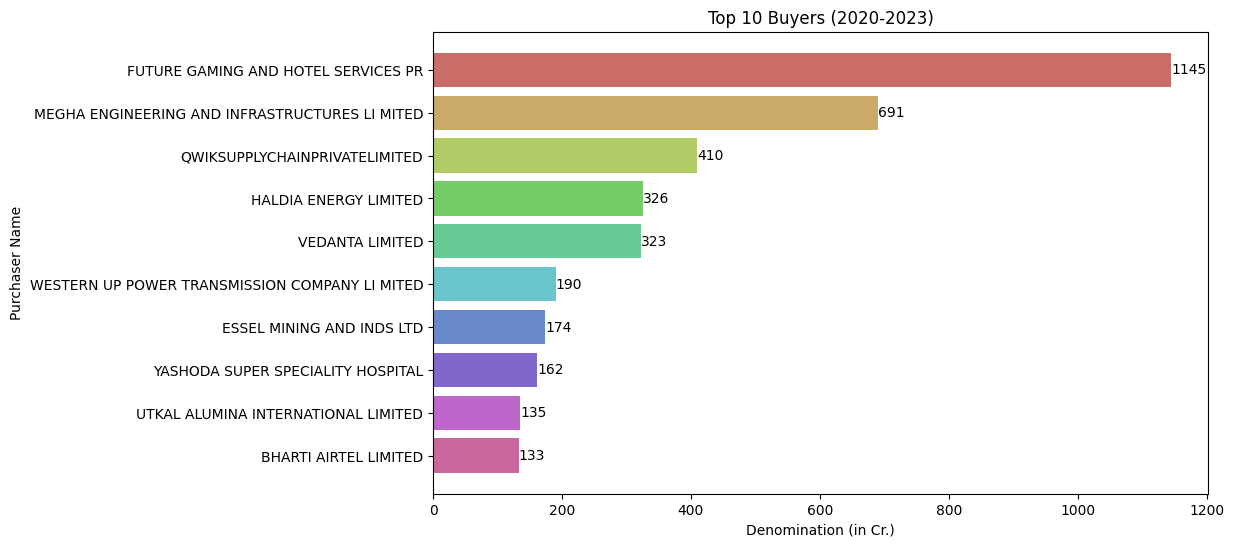

In [16]:
# Aggregating by Purchaser
pdf = agg_buy_df.groupby('Purchaser Name')['Denomination'].sum().reset_index().sort_values(['Denomination'], ascending=[False]).head(10)
# Converting Denomination to Crores and rounding off
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf,
           y='Purchaser Name',
           x='Denomination',
           palette='hls')
# This code labels each bar with the value
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
plt.ylabel('Purchaser Name')
plt.xlabel('Denomination (in Cr.)')
plt.title('Top 10 Buyers (2020-2023)')
plt.show()

- 'Future Gaming and Hotel Services PR' is the top buyers of Electoral Bond worth **1145 Cr. INR**  
- Second in the list is 'Megha and Engineering and Infrastructures Limited' which is not even close to the top 1 with **691 Cr. INR**  
- 'Bharti Airtel' is number 10 in the list with **133 Cr. INR** which is close to **10 %** of top 1

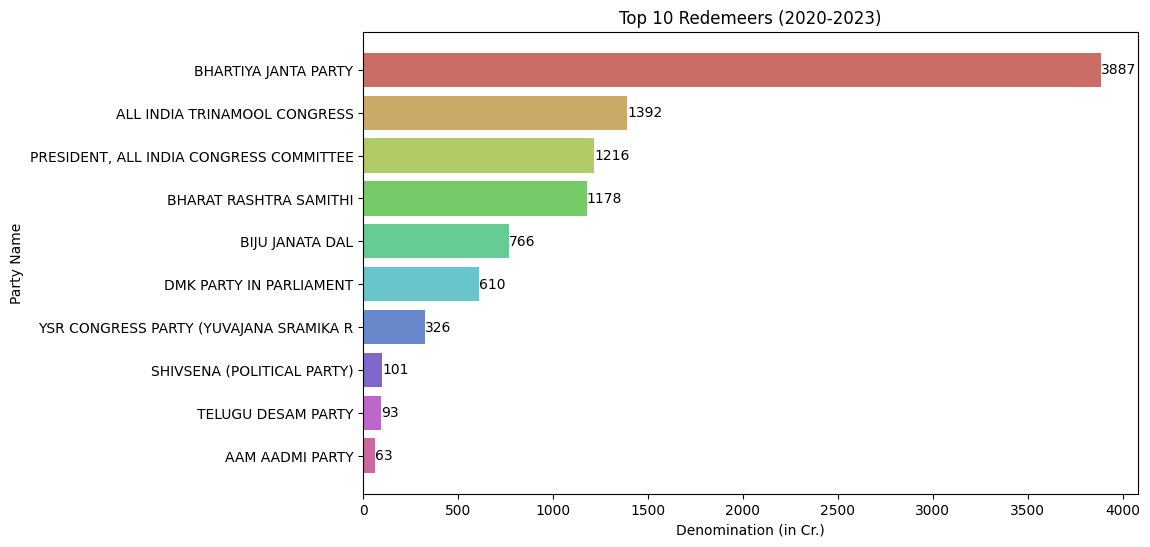

In [17]:
# Aggregating by Party
pdf = agg_rec_df.groupby('Party Name')['Denomination'].sum().reset_index().sort_values(['Denomination'], ascending=[False]).head(10)
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf,
           y='Party Name',
           x='Denomination',
           palette='hls')
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
plt.ylabel('Party Name')
plt.xlabel('Denomination (in Cr.)')
plt.title('Top 10 Redemeers (2020-2023)')
plt.show()

- **'BJP'** is at the top with whopping **3887 Cr. INR** encashment of Electoral Bonds  
- **'TMC'** is 2nd with **1392 Cr. INR** which is not even half of BJP  
- **'AAP'** is at number 10 with **63 Cr. INR** which is just **1.6\% of BJP**

### Yearly purchase and redemption of Bonds

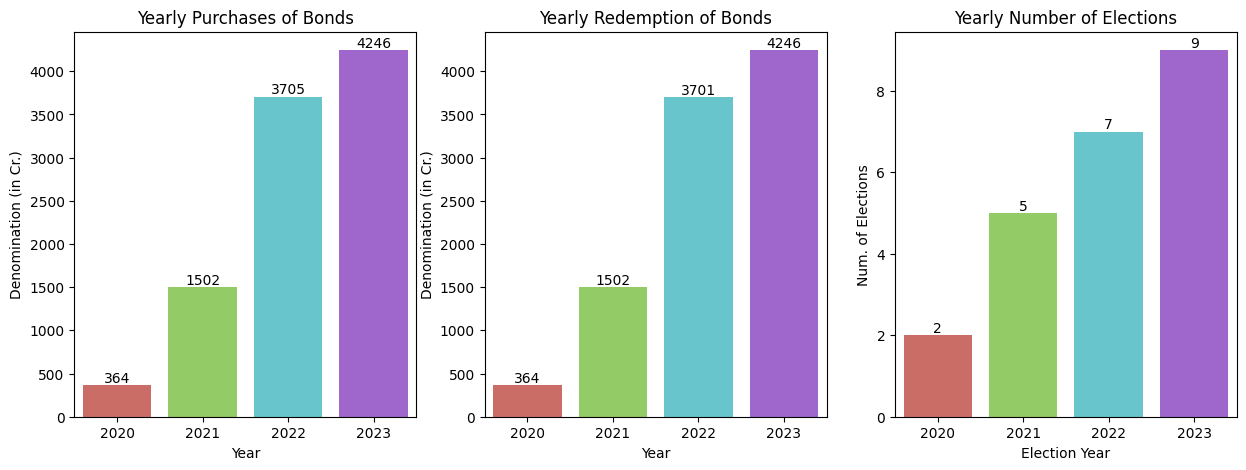

In [18]:
#Aggregating Purchase Data Yearly for plot
pdf = agg_buy_df[['Year', 'Denomination']].groupby(by='Year').sum().reset_index()
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')

fig, axes = plt.subplots(1,3,sharex=True, figsize=(15,5))

ax = sns.barplot(data=pdf,
           x='Year',
           y='Denomination',
           palette='hls', ax= axes[0])
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Denomination (in Cr.)')
axes[0].set_title('Yearly Purchases of Bonds')

#Aggregating Redemption Data Yearly for plot
pdf = agg_rec_df[['Year', 'Denomination']].groupby(by='Year').sum().reset_index()
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')

ax = sns.barplot(data=pdf,
           x='Year',
           y='Denomination',
           palette='hls', ax = axes[1])
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Denomination (in Cr.)')
axes[1].set_title('Yearly Redemption of Bonds')

# Plotting Election data
ax = sns.barplot(data=agg_elec_date,
                x='Election Year',
                y='Num. of Elections',
                palette='hls', ax = axes[2])
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
axes[2].set_title('Yearly Number of Elections')
plt.show()

- We can clearly see, Purchase and Redemption are same **except 2022**  
- Comparing the 3rd Graph with the first 2, we can say number of Elections happening in a year is correlated to amount of Electoral bonds in that year

### Quarterly purchase and redemption of Bonds

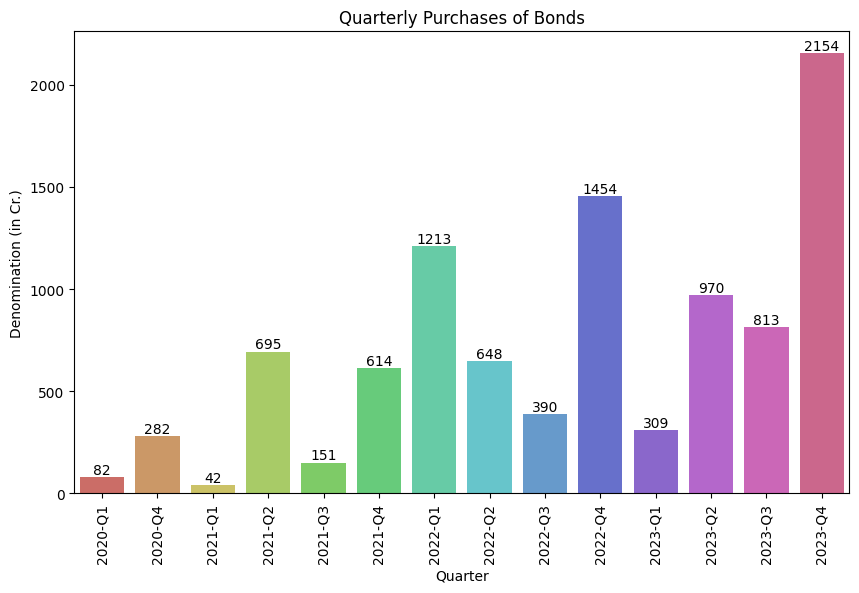

In [19]:
#Aggregating purchase Data Quarterly for plot
pdf = agg_buy_df[['Y-Q', 'Denomination']].groupby(by='Y-Q').sum().reset_index()
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf,
           x='Y-Q',
           y='Denomination',
           palette='hls')
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
plt.xlabel('Quarter')
plt.ylabel('Denomination (in Cr.)')
plt.title('Quarterly Purchases of Bonds')
plt.tick_params(axis='x', rotation=90)
plt.show()

- We see spikes in purchase of bonds close to when there is an Election  
- For eg. 
    - in 2021 There were elections in Q2, hence we see a spike in Q2 of 2021  
    - in 2023 Q4, there were elections for 5 states, hence we see a huge spike in purchase of bonds

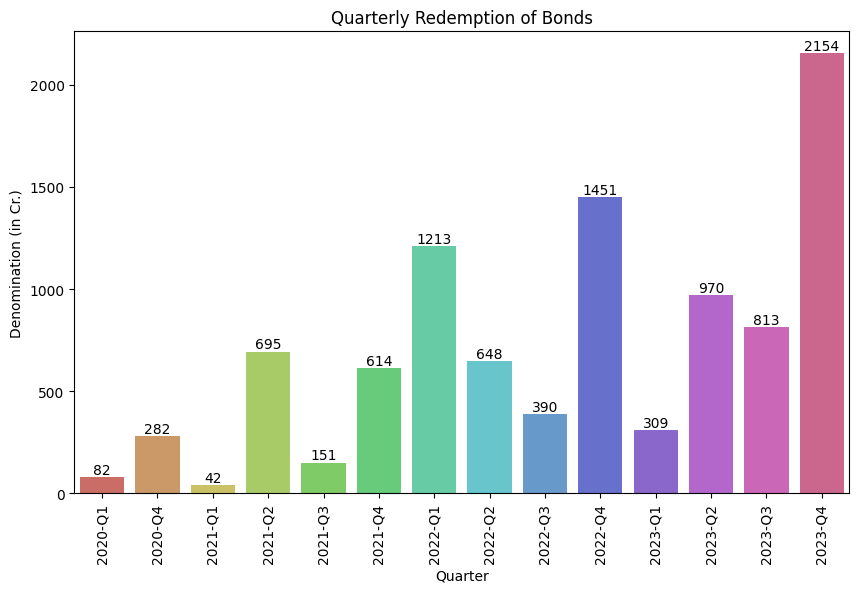

In [20]:
#Aggregating Redemption Data Quarterly for plot
pdf = agg_rec_df[['Y-Q', 'Denomination']].groupby(by='Y-Q').sum().reset_index()
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf,
           x='Y-Q',
           y='Denomination',
           palette='hls')
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
plt.xlabel('Quarter')
plt.ylabel('Denomination (in Cr.)')
plt.title('Quarterly Redemption of Bonds')
plt.tick_params(axis='x', rotation=90)
plt.show()

- Redemption of bonds are very similar to purchase, except Q4 2022

### Top 3 Purchases every year

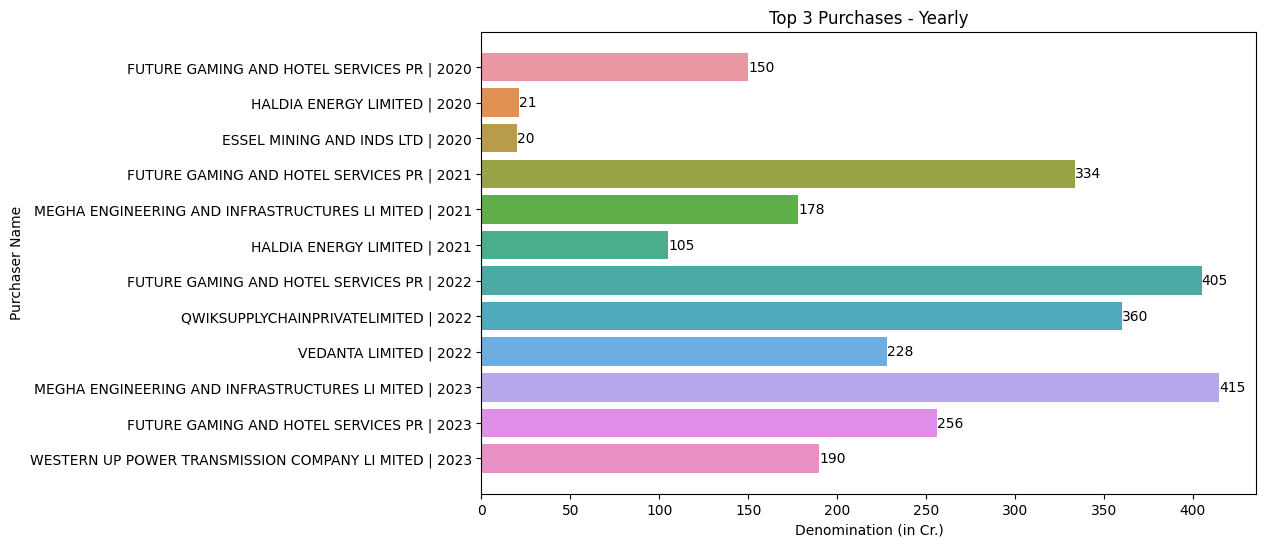

In [21]:
# Aggregating purchase data by Year and Purchaser to find the top 3 for each Year
pdf = agg_buy_df.groupby(by=['Year','Purchaser Name'])['Denomination'].sum().reset_index()
pdf['Rank'] = pdf.sort_values(['Denomination'], ascending=[False]).groupby(['Year']).cumcount()+1
pdf = pdf.loc[pdf['Rank']<=3].sort_values(['Year','Rank'])
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')
pdf['label'] = pdf['Purchaser Name'].astype('str')+' | '+pdf['Year'].astype('str')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf,
           y='label',
           x='Denomination',
           )
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
plt.ylabel('Purchaser Name')
plt.xlabel('Denomination (in Cr.)')
plt.title('Top 3 Purchases - Yearly')
plt.show()

- **'Future Gaming...' is in the top 3** position for all Years  
- We see **'Haldia Energy'** ,which is a company in West Bengal, making **top 3 in 2020 and 2021**. Just before the elections of West Bengal in 2021.  
- We also see **'Megha Engineer...' in top 3** in 2021 and 2023

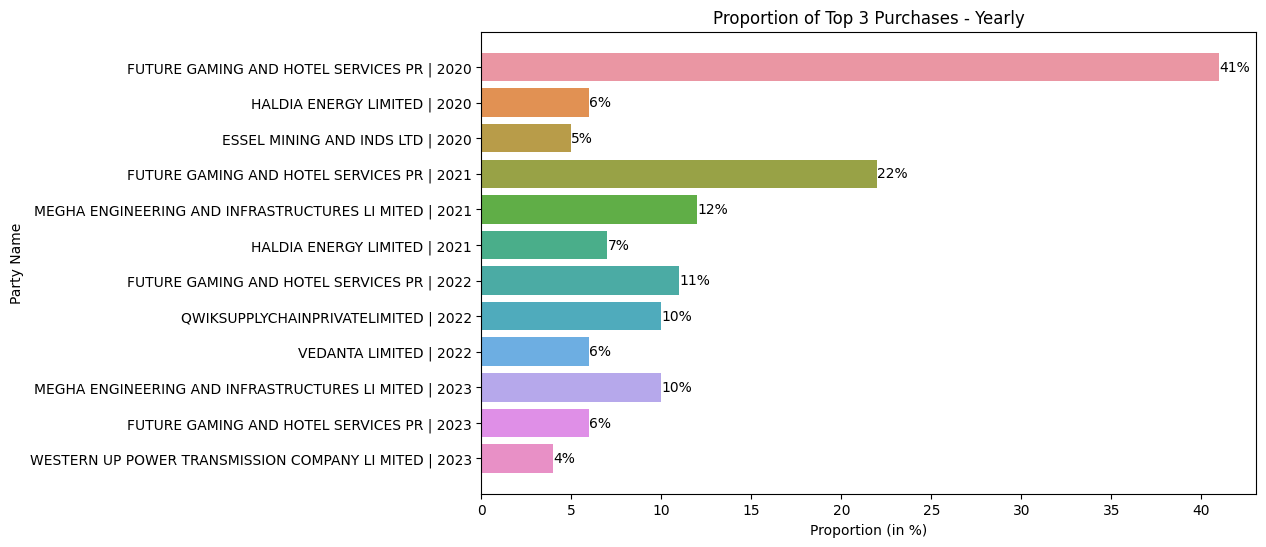

In [22]:
# Calculating Proportions (percentage) of contribution for each year

pdf1 = agg_buy_df.groupby('Year')['Denomination'].sum().reset_index().rename(columns={'Denomination':'Yearly_Denom'})
pdf1 = pdf1.set_index('Year').join(pdf.set_index('Year'), on='Year')
pdf1['Proportion'] = round(pdf1['Denomination']*100*10000000 / pdf1['Yearly_Denom']).astype('int')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf1,
           y='label',
           x='Proportion',
           )
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f%%')
plt.ylabel('Party Name')
plt.xlabel('Proportion (in %)')
plt.title('Proportion of Top 3 Purchases - Yearly')
plt.show()

- In 2020, **'Future Gaming...' donated 41%** of entire E. bonds worth for that year.  
- In 2022 and 2023, we see companies donated less than 15% of E. bonds worth for those year.  

### Top 3 Redemptions every Year

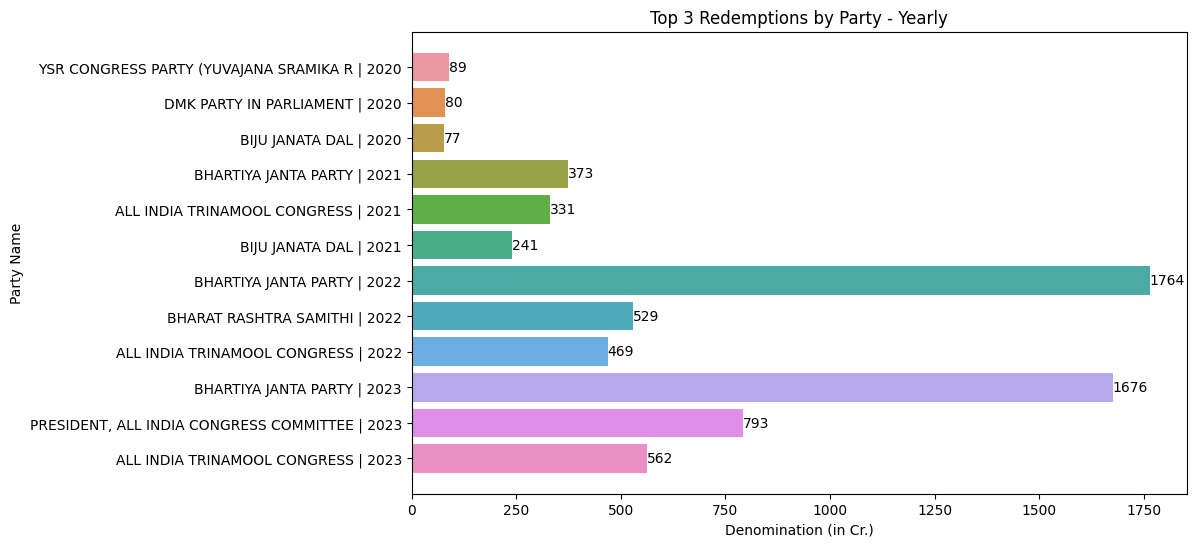

In [23]:
# Aggregating purchase data by Year and Redeemer to find the top 3 for each Year

pdf = agg_rec_df.groupby(by=['Year','Party Name'])['Denomination'].sum().reset_index()
pdf['Rank'] = pdf.sort_values(['Denomination'], ascending=[False]).groupby(['Year']).cumcount()+1
pdf = pdf.loc[pdf['Rank']<=3].sort_values(['Year','Rank'], ascending=[True,True])
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')
pdf['label'] = pdf['Party Name'].astype('str')+' | '+pdf['Year'].astype('str')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf,
           y='label',
           x='Denomination',
           )
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
plt.ylabel('Party Name')
plt.xlabel('Denomination (in Cr.)')
plt.title('Top 3 Redemptions by Party - Yearly')

plt.show()

- In 2020, there were very less redemptions as there were elections in only 2 stats (Delhi and Bihar)  
- After 2020, we see **BJP** in the top every year, and **TMC** in top 3 every year  
- Even though the elections for West Bengal were over in 2021, **TMC** is in top even in 2022 and 2023

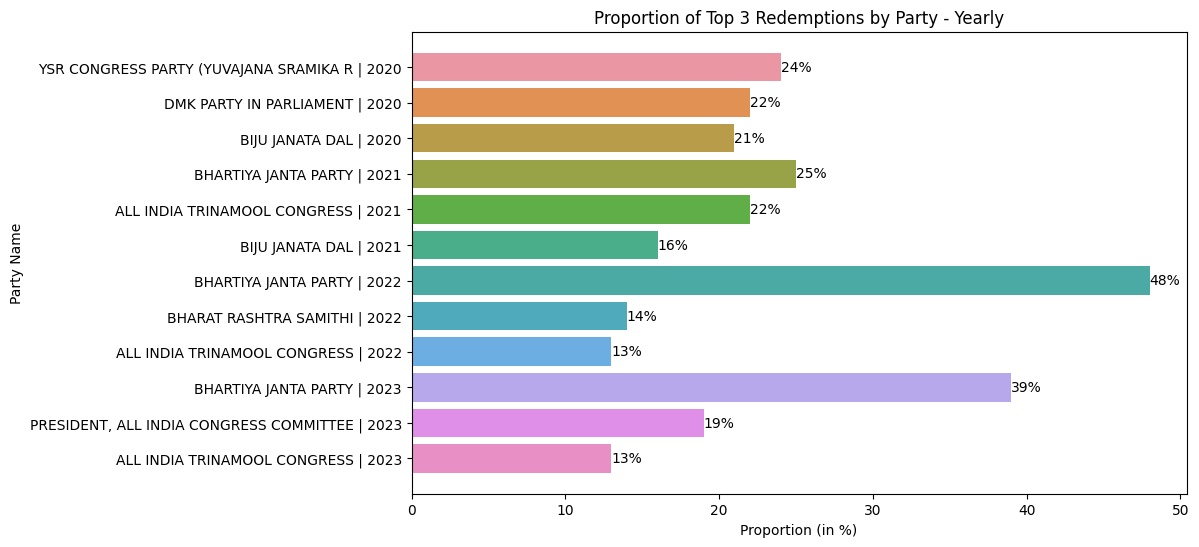

In [24]:
# Calculating Proportions (percentage) of redemption for each year

pdf1 = agg_rec_df.groupby('Year')['Denomination'].sum().reset_index().rename(columns={'Denomination':'Yearly_Denom'})
pdf1 = pdf1.set_index('Year').join(pdf.set_index('Year'), on='Year')
pdf1['Proportion'] = round(pdf1['Denomination']*100*10000000 / pdf1['Yearly_Denom']).astype('int')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=pdf1,
           y='label',
           x='Proportion',
           )
ax.margins(y=0.05)
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f%%')
plt.ylabel('Party Name')
plt.xlabel('Proportion (in %)')
plt.title('Proportion of Top 3 Redemptions by Party - Yearly')

plt.show()

- In 2022, **BJP encashed 48%** of entire E. bonds worth for that Year. Which can be related to **5 out of 7 state election wins by BJP** in that year
- In 2023, the percentage reduced to **39%**, Where NDA (BJP) **won 6 out of 9** state elections in that year  

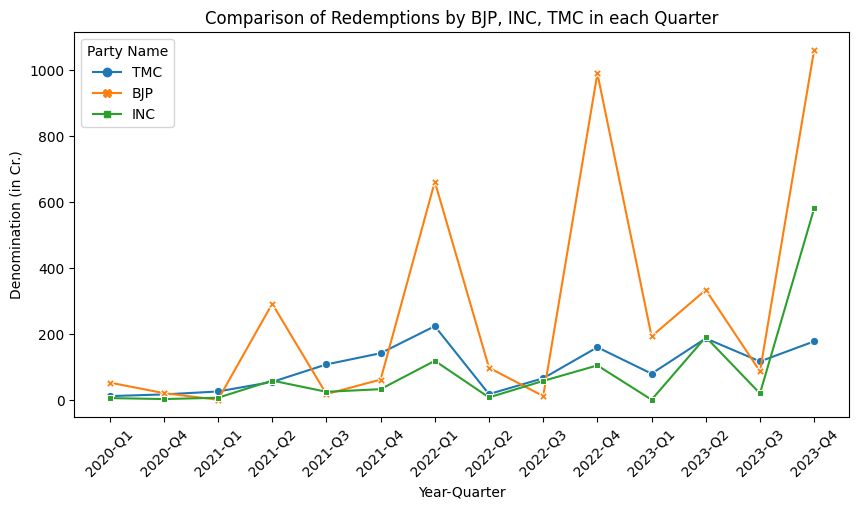

In [25]:
# Aggregating redemption data Quarterly for BJP, TMC and INC

pdf = agg_rec_df.groupby(by=['Y-Q', 'Party Name'])['Denomination'].sum().reset_index()
pdf = pdf.loc[pdf['Party Name'].isin(['BHARTIYA JANTA PARTY', 'PRESIDENT, ALL INDIA CONGRESS COMMITTEE', 'ALL INDIA TRINAMOOL CONGRESS'])]
pdf['Denomination'] = round(pdf['Denomination']/10000000).astype('int')

d1 = {'BHARTIYA JANTA PARTY':'BJP', 'PRESIDENT, ALL INDIA CONGRESS COMMITTEE':'INC', 'ALL INDIA TRINAMOOL CONGRESS':'TMC'}
pdf['Party Name'] = pdf['Party Name'].map(d1)

plt.figure(figsize=(10,5))
sns.lineplot(data=pdf,
            x='Y-Q',
            y='Denomination',
            hue='Party Name',
            style='Party Name',
            markers=True, dashes=False,
            )
plt.ylabel('Denomination (in Cr.)')
plt.xlabel('Year-Quarter')
plt.title('Comparison of Redemptions by BJP, INC, TMC in each Quarter')
plt.tick_params(axis='x', rotation=45)
plt.show()

- We can see **'BJP'** in the **top** most of the time  
- **'TMC'** is second in most Quarters  
- **'IND'** ranked higher than **'TMC'** only in Q4 of 2023  

**If we had an identifier to link the purchases and encashment then there was opportunity for further analysis**